In [1]:
pip install surprise

     |████████████████████████████████| 6.5MB 4.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678243 sha256=2938e39f844b67ab237fb6fc734a61b18989ea4a09fe61802af95e99813c61cf
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
# import packages
import numpy as np 
import pandas as pd 
import os 
from matplotlib import pyplot as plt
import warnings
import time
import io
from scipy.sparse import coo_matrix
warnings.filterwarnings('ignore')

from surprise.dataset import Dataset
from surprise.similarities import pearson
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import BaselineOnly

from surprise import Reader
from surprise.model_selection.split import KFold, train_test_split
from surprise.accuracy import mse, rmse
from sklearn import metrics

In [0]:
#from google.colab import files
#uploaded = files.upload()
#data_directory = r'/Users/rover/Desktop/2020 Winter/ECE 219/Project 3/ml-latest-small'
#os.chdir(data_directory)

# links = pd.read_csv('links.csv')
# movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv') # only movie rating is used in this project
tags = pd.read_csv('tags.csv') # used for movie genre

num_movie = len(ratings['movieId'].unique())
num_user = len(ratings['userId'].unique())

# create rating matrix R
matrix = coo_matrix((ratings.rating.to_list(), (ratings.userId.to_list(), ratings.movieId.to_list()))).toarray()
R = pd.DataFrame(index = range(611), columns= ratings['movieId'].unique(), data = matrix[:, ratings.movieId.unique()])
R = R.drop(R.index[0])
R.replace(0, np.nan, inplace = True)

In [11]:
tags.tag.describe()

count                 3683
unique                1589
top       In Netflix queue
freq                   131
Name: tag, dtype: object

### Model-based collaborative filtering

#### Non-negative matrix factorization (NNMF)

In [0]:
# prepare data
file_path = os.path.expanduser(r'/content/ratings.csv')
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

# count the number of ratings for each movie
movie_rate_frequency = pd.DataFrame(index = ratings.movieId.unique(), data = num_user - R.isna().sum(axis = 0))
movie_rate_frequency = movie_rate_frequency.sort_values(by = 0, ascending=False)

# compute the rating variance of each movie
movie_rate_var = pd.DataFrame(index = ratings.movieId.unique(), data = R.var(axis = 0))
movie_rate_var.replace(np.nan, 0, inplace = True)

# prepare trimmed movieId
movie_frevar = pd.DataFrame(index = ratings.movieId.unique())
movie_frevar['frequency'] = num_user - R.isna().sum(axis = 0)
movie_frevar['variance'] = R.var(axis = 0)
popular_movieId = movie_rate_frequency[movie_frevar['frequency'] > 2].index.tolist()
popular_movieId = list(map(str, popular_movieId))

unpopular_movieId = movie_rate_frequency[movie_frevar['frequency'] <= 2].index.tolist()
unpopular_movieId = list(map(str, unpopular_movieId))

highvar_movieId = movie_rate_frequency[(movie_frevar['frequency'] >= 5) & (movie_frevar['variance'] >= 2)].index.tolist()
highvar_movieId = list(map(str, highvar_movieId))

In [0]:
class nmf_kfold():
    def __init__(self, num_factors, num_epoch, data):
        self.model = NMF(n_factors = num_factors, n_epochs = num_epoch, biased = True)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

$\textbf{Question 17}$ Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.


In [14]:
# define number of factors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_17, mean_mae_17 = [], []

# perform k-fold cross validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 30, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = False)
    mean_rmse_17.append(performance['mean_rmse'])
    mean_mae_17.append(performance['mean_mse'])

RMSE: 0.8489
MSE: 0.7206
RMSE: 0.8652
MSE: 0.7485
RMSE: 0.8575
MSE: 0.7353
RMSE: 0.8702
MSE: 0.7573
RMSE: 0.8756
MSE: 0.7666
RMSE: 0.8687
MSE: 0.7547
RMSE: 0.8673
MSE: 0.7522
RMSE: 0.8779
MSE: 0.7707
RMSE: 0.8807
MSE: 0.7756
RMSE: 0.8699
MSE: 0.7567
RMSE: 0.8770
MSE: 0.7692
RMSE: 0.8660
MSE: 0.7499
RMSE: 0.8599
MSE: 0.7395
RMSE: 0.8759
MSE: 0.7673
RMSE: 0.8516
MSE: 0.7253
RMSE: 0.8704
MSE: 0.7576
RMSE: 0.8757
MSE: 0.7669
RMSE: 0.8717
MSE: 0.7599
RMSE: 0.8725
MSE: 0.7612
RMSE: 0.8715
MSE: 0.7595
RMSE: 0.8802
MSE: 0.7747
RMSE: 0.8681
MSE: 0.7536
RMSE: 0.8735
MSE: 0.7630
RMSE: 0.8689
MSE: 0.7550
RMSE: 0.8512
MSE: 0.7246
RMSE: 0.8706
MSE: 0.7579
RMSE: 0.8790
MSE: 0.7727
RMSE: 0.8583
MSE: 0.7367
RMSE: 0.8802
MSE: 0.7748
RMSE: 0.8801
MSE: 0.7745
RMSE: 0.8707
MSE: 0.7581
RMSE: 0.8730
MSE: 0.7620
RMSE: 0.8589
MSE: 0.7378
RMSE: 0.8648
MSE: 0.7480
RMSE: 0.8853
MSE: 0.7837
RMSE: 0.8696
MSE: 0.7563
RMSE: 0.8753
MSE: 0.7662
RMSE: 0.8787
MSE: 0.7721
RMSE: 0.8729
MSE: 0.7620
RMSE: 0.8711
MSE: 0.7588


0.8651604651015309
0.7485026303746972
0
0


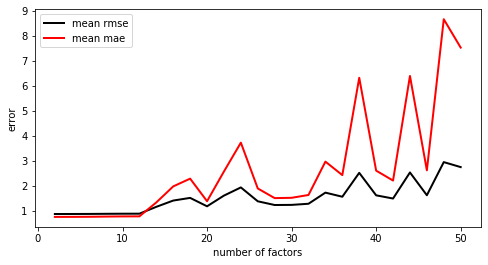

In [15]:
print(min(mean_rmse_17))
print(min(mean_mae_17))
print(np.argmin(mean_rmse_17))
print(np.argmin(mean_mae_17))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_17, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_17, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 18}$ Use the plot from question 17, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

In [16]:
print(mean_rmse_17)
print(mean_mae_17)

[0.8651604651015309, 0.8659629084607487, 0.8680952776629348, 0.8729505536934193, 0.8769952174517656, 0.8780862121083474, 1.1527606256531684, 1.4039174962904077, 1.510627706471733, 1.1736984169775138, 1.602833720782984, 1.9297888218640848, 1.3743067839364531, 1.2255075365334906, 1.2304197167554527, 1.2757000661263291, 1.7216055945087125, 1.5568066692292388, 2.5146345938476125, 1.6133419461471288, 1.4851150812662617, 2.5291413186494305, 1.6169512915498716, 2.9441660218284422, 2.744459911624635]
[0.7485026303746972, 0.7498917588297992, 0.7535894111006879, 0.7620426691936475, 0.7691206114332696, 0.7710353958947855, 1.3288570600562841, 1.970984336390327, 2.2819960675600486, 1.3775679740155218, 2.5690759364790243, 3.724084896991573, 1.888719136373757, 1.5018687221003848, 1.5139326793805683, 1.6274106587147206, 2.9639258230436973, 2.4236470053566364, 6.323387140575147, 2.602872235197805, 2.2055668046044947, 6.396555809699779, 2.614531479244798, 8.668113564089115, 7.532060206514699]


$\textbf{Question 19}$ Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [22]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_19, mean_mae_19 = [], []

# perform k-fold cross-validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = popular_movieId)
    mean_rmse_19.append(performance['mean_rmse'])
    mean_mae_19.append(performance['mean_mse'])

RMSE: 0.8566
MSE: 0.7338
RMSE: 0.8521
MSE: 0.7260
RMSE: 0.8613
MSE: 0.7419
RMSE: 0.8631
MSE: 0.7450
RMSE: 0.8636
MSE: 0.7458
RMSE: 0.8524
MSE: 0.7266
RMSE: 0.8551
MSE: 0.7313
RMSE: 0.8421
MSE: 0.7091
RMSE: 0.8449
MSE: 0.7139
RMSE: 0.8534
MSE: 0.7283
RMSE: 0.8485
MSE: 0.7199
RMSE: 0.8406
MSE: 0.7066
RMSE: 0.8585
MSE: 0.7370
RMSE: 0.8510
MSE: 0.7242
RMSE: 0.8466
MSE: 0.7167
RMSE: 0.8607
MSE: 0.7409
RMSE: 0.8427
MSE: 0.7101
RMSE: 0.8686
MSE: 0.7544
RMSE: 0.8626
MSE: 0.7441
RMSE: 0.8539
MSE: 0.7291
RMSE: 0.8627
MSE: 0.7442
RMSE: 0.8494
MSE: 0.7215
RMSE: 0.8521
MSE: 0.7260
RMSE: 0.8421
MSE: 0.7091
RMSE: 0.8578
MSE: 0.7359
RMSE: 0.8716
MSE: 0.7597
RMSE: 0.8549
MSE: 0.7308
RMSE: 0.8549
MSE: 0.7309
RMSE: 0.8446
MSE: 0.7133
RMSE: 0.8482
MSE: 0.7194
RMSE: 0.8562
MSE: 0.7330
RMSE: 0.8608
MSE: 0.7410
RMSE: 0.8536
MSE: 0.7287
RMSE: 0.8499
MSE: 0.7223
RMSE: 0.8544
MSE: 0.7300
RMSE: 0.8501
MSE: 0.7227
RMSE: 0.8541
MSE: 0.7294
RMSE: 0.8507
MSE: 0.7236
RMSE: 0.8512
MSE: 0.7245
RMSE: 0.8408
MSE: 0.7070


0.8406119186006451
0.7066283976934576


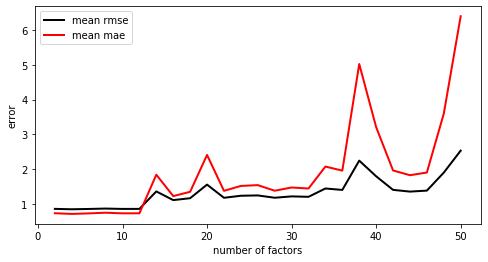

In [23]:
print(min(mean_rmse_19))
print(min(mean_mae_19))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_19, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_19, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 20}$ Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [24]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_20, mean_mae_20 = [], []

# perform k-fold cross-validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_20.append(performance['mean_rmse'])
    mean_mae_20.append(performance['mean_mse'])

RMSE: 1.0451
MSE: 1.0923
RMSE: 1.0417
MSE: 1.0851
RMSE: 1.0815
MSE: 1.1696
RMSE: 1.0779
MSE: 1.1618
RMSE: 1.0540
MSE: 1.1108
RMSE: 1.1035
MSE: 1.2177
RMSE: 1.0338
MSE: 1.0687
RMSE: 1.0214
MSE: 1.0433
RMSE: 1.0750
MSE: 1.1557
RMSE: 1.0618
MSE: 1.1274
RMSE: 1.0711
MSE: 1.1472
RMSE: 1.1038
MSE: 1.2183
RMSE: 1.1021
MSE: 1.2147
RMSE: 1.0542
MSE: 1.1113
RMSE: 1.0755
MSE: 1.1566
RMSE: 1.0568
MSE: 1.1168
RMSE: 1.0350
MSE: 1.0713
RMSE: 1.0668
MSE: 1.1380
RMSE: 1.0567
MSE: 1.1167
RMSE: 1.0933
MSE: 1.1954
RMSE: 1.0915
MSE: 1.1913
RMSE: 1.0826
MSE: 1.1720
RMSE: 1.0438
MSE: 1.0895
RMSE: 1.1111
MSE: 1.2345
RMSE: 1.0866
MSE: 1.1807
RMSE: 1.0422
MSE: 1.0861
RMSE: 1.0718
MSE: 1.1488
RMSE: 1.0844
MSE: 1.1759
RMSE: 1.1168
MSE: 1.2472
RMSE: 1.0968
MSE: 1.2031
RMSE: 1.0636
MSE: 1.1312
RMSE: 1.1290
MSE: 1.2746
RMSE: 1.1384
MSE: 1.2961
RMSE: 1.0846
MSE: 1.1764
RMSE: 1.0831
MSE: 1.1732
RMSE: 1.1023
MSE: 1.2152
RMSE: 1.1156
MSE: 1.2446
RMSE: 1.0556
MSE: 1.1143
RMSE: 1.1163
MSE: 1.2461
RMSE: 1.0563
MSE: 1.1157


1.0416955103148322
1.0851295362100788


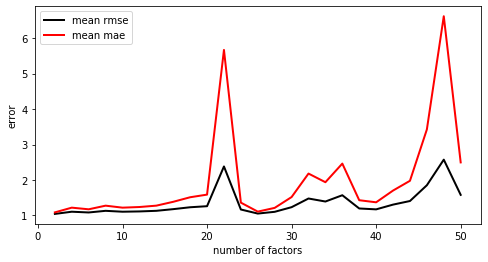

In [25]:
print(min(mean_rmse_20))
print(min(mean_mae_20))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_20, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_20, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 21}$ Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [26]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_21, mean_mae_21 = [], []

# perform k-fold cross-validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_21.append(performance['mean_rmse'])
    mean_mae_21.append(performance['mean_mse'])

RMSE: 1.0572
MSE: 1.1178
RMSE: 1.0764
MSE: 1.1587
RMSE: 1.0609
MSE: 1.1256
RMSE: 1.0622
MSE: 1.1283
RMSE: 1.0546
MSE: 1.1121
RMSE: 1.0167
MSE: 1.0336
RMSE: 1.0184
MSE: 1.0371
RMSE: 1.0463
MSE: 1.0948
RMSE: 1.0904
MSE: 1.1890
RMSE: 1.0558
MSE: 1.1147
RMSE: 1.0946
MSE: 1.1982
RMSE: 1.1422
MSE: 1.3046
RMSE: 1.0592
MSE: 1.1218
RMSE: 1.0213
MSE: 1.0430
RMSE: 1.0695
MSE: 1.1438
RMSE: 1.0160
MSE: 1.0323
RMSE: 1.0576
MSE: 1.1185
RMSE: 1.0601
MSE: 1.1237
RMSE: 1.0848
MSE: 1.1768
RMSE: 1.1128
MSE: 1.2382
RMSE: 1.1392
MSE: 1.2978
RMSE: 1.0806
MSE: 1.1678
RMSE: 1.0461
MSE: 1.0943
RMSE: 1.0842
MSE: 1.1756
RMSE: 1.1141
MSE: 1.2412
RMSE: 1.0387
MSE: 1.0790
RMSE: 1.0838
MSE: 1.1746
RMSE: 1.0943
MSE: 1.1975
RMSE: 1.0876
MSE: 1.1830
RMSE: 1.0634
MSE: 1.1309
RMSE: 1.0806
MSE: 1.1676
RMSE: 1.0977
MSE: 1.2050
RMSE: 1.0888
MSE: 1.1856
RMSE: 1.1089
MSE: 1.2296
RMSE: 1.0614
MSE: 1.1267
RMSE: 1.0486
MSE: 1.0995
RMSE: 1.1761
MSE: 1.3833
RMSE: 1.0798
MSE: 1.1659
RMSE: 1.1115
MSE: 1.2355
RMSE: 1.0991
MSE: 1.2080


0.9999158172798438
0.999831641646418


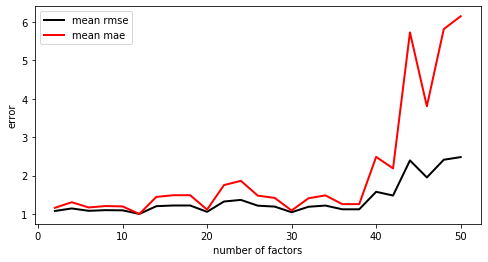

In [27]:
print(min(mean_rmse_21))
print(min(mean_mae_21))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_21, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_21, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 22}$: Plot the ROC curves for the NNMF-based collaborative filter designed in question 17 for threshold values [2.5,3,3.5,4]. For the ROC plot- ting use the optimal number of latent factors found in question 18. For each of the plots, also report the area under the curve (AUC) value.

The roc areas of the 4 thresholds are [0.7558597731845105, 0.7539469572053783, 0.75435606027009, 0.7510821831577852] , respectively


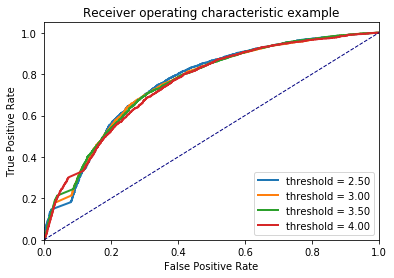

In [15]:
# use k = 12 from problem 17
model_22 = NMF(n_factors = 3)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)
model_22.fit(data_train)
test_pred_22 = model_22.test(data_test)

# make ROC plot
true_test_rating = [data_test[p][2] for p in range(len(data_test))]
pred_test_rating = [test_pred_22[p][3] for p in range(len(test_pred_22))]
threshold = [2.5, 3, 3.5, 4]
fprs, tprs = [], []
roc_auc = []
for t in threshold:
    true_test_bi = np.array(true_test_rating) > t
    fpr, tpr, _ = metrics.roc_curve(true_test_bi, pred_test_rating)
    roc_auc.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)

for i in range(4):
    plt.plot(fprs[i], tprs[i], lw=2, label = 'threshold = %.2f'%threshold[i])

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print('The roc areas of the 4 thresholds are', roc_auc, ', respectively')

$\textbf{Question 23}$: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

In [18]:
# compute latent factors of movies using NMF
df2 = pd.read_csv('movies.csv', names = ['movieid', 'title', 'genres'],header=0)
model_23 = NMF(n_factors = 20)
model_23.fit(data.build_full_trainset())
V = model_23.qi

for k in range(0,20):
    kMovies = V[:,k]
    moviesTuple = []
    for i in range(len(kMovies)):
        moviesTuple.append((i, kMovies[i]))
    moviesTuple.sort(key = lambda x:x[1], reverse=True)
    print ("for k = ", k)
    for mt in moviesTuple[0:10]:
        print (df2['genres'][mt[0]])


'''
# collect the inner item ids with the top 10 largest latent factors
top_movie_factors = np.empty(shape = [10, 20])
top_factors_movieId = np.empty(shape = [10, 20])
for i in range(20):
    top_factors_movieId[:, i] = V[:,i].argsort()[-10:]
    top_movie_factors[:, i] = np.sort(V[:,i])[-10:]

# report the results for column 0
col_zero_ids = []
col_zero_genres = []

raw_ids = [model_23.trainset.to_raw_iid(p) for p in top_factors_movieId[:,19]]
movie_genres = [tags.loc[tags['movieId'] == int(q), 'tag'].values for q in raw_ids]
'''

for k =  0
Horror|Sci-Fi
Horror|Mystery|Thriller
Comedy
Drama
Drama|Romance|War
Adventure|Animation|Children|Comedy
Comedy
Musical
Comedy
Adventure|Children
for k =  1
Comedy
Drama
Comedy|Drama
Comedy
Drama
Comedy|Crime|Mystery
Comedy
Drama
Drama
Adventure|Comedy|Fantasy|Musical
for k =  2
Comedy|Romance
Film-Noir|Thriller
Drama
Drama
Drama
Comedy|Romance
Action|Drama|Thriller
Comedy
Crime
Crime|Drama|Film-Noir|Thriller
for k =  3
Horror
Action|Drama|Thriller
Comedy|Romance
Action|Comedy|Sci-Fi
Drama|Thriller
Comedy
Comedy|Drama
Comedy|Drama|Thriller
Drama|Mystery|Thriller
Comedy|Thriller
for k =  4
Comedy
Drama
Action|Adventure|Drama|Thriller
Adventure|Animation|Children|Comedy
Comedy|Crime|Romance|Thriller
Drama|Thriller
Animation|Documentary
Drama|Fantasy|Horror|Romance
Action|Adventure|Fantasy
Comedy|Romance
for k =  5
Comedy
Drama|Mystery
Drama
Adventure|Comedy|Fantasy
Drama
Drama|Film-Noir
Drama|Musical
Comedy|Crime
Drama
Comedy|Mystery
for k =  6
Documentary
Crime|Drama|Thriller

"\n# collect the inner item ids with the top 10 largest latent factors\ntop_movie_factors = np.empty(shape = [10, 20])\ntop_factors_movieId = np.empty(shape = [10, 20])\nfor i in range(20):\n    top_factors_movieId[:, i] = V[:,i].argsort()[-10:]\n    top_movie_factors[:, i] = np.sort(V[:,i])[-10:]\n\n# report the results for column 0\ncol_zero_ids = []\ncol_zero_genres = []\n\nraw_ids = [model_23.trainset.to_raw_iid(p) for p in top_factors_movieId[:,19]]\nmovie_genres = [tags.loc[tags['movieId'] == int(q), 'tag'].values for q in raw_ids]\n"